In [1]:
import datetime, urllib, re, math, json, requests,io
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy import optimize
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML



try:
    from packaging import version
except ImportError:
    !pip install packaging

if( version.parse(pd.__version__) < version.parse("0.23.4")):
    print("update pandas")
    !pip install pandas --upgrade #--ignore-installed
    print(version.parse(pd.__version__))
#might need this
#!pip install --upgrade pip    

# Constants

In [66]:



#** pandas
# change max number of rows to show
pd.set_option('display.max_rows', 300)

#** plotters formats

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cycler import cycler
#* dpi size
plt.rcParams['figure.dpi'] = 200
myFmt = mdates.DateFormatter('%m/%d')
myLocator = mticker.MultipleLocator(7)

default_cycler = (cycler(marker=['.','*','+','s','x']) *
                  cycler(color=['b','g','k','m','y','c','r']) *
                  cycler(linestyle=['-']))

plt.rc('axes', prop_cycle=default_cycler)

#** panda data frame styles
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


# 3rd party data source real time data, from a spin of JHU
http://blog.lazd.net/coronadatascraper/

In [3]:
idx = pd.IndexSlice
df = pd.read_csv("http://blog.lazd.net/coronadatascraper/data.csv",parse_dates=True)
df[["city","county","state","country"]] =df[["city","county","state","country"]].fillna("NA")
dataCS =df.set_index(["city","county","state","country"])


# create county with state as NA, but summin across states
for ctr in dataCS.index.levels[3]:
    if not idx["NA","NA","NA",ctr]    in dataCS.index: 
        dataCS.loc[idx["NA","NA","NA",ctr],:] =dataCS.loc[idx["NA","NA",:,ctr],:].sum()
        
#use index slice for more easy/clean access


IClmns= idx["cases","death","recovered","tested",'url']
ctrMask = dataCS["cases"] > 1000
dataCS.loc[idx["NA","NA","NA",ctrMask],IClmns].sort_values(by="cases",ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


cases  death  recovered    tested  \
city county state country                                        
NA   NA     NA    CHN      80931.0    NaN    70430.0       0.0   
                  ITA      41035.0    NaN     4440.0       NaN   
                  IRN      18407.0    NaN     5710.0       NaN   
                  ESP      16947.0    NaN        2.0       NaN   
                  DEU      15320.0    NaN      115.0       NaN   
                  FRA      12680.0    NaN        NaN       NaN   
                  USA      11723.0    NaN        NaN  103945.0   
                  KOR       8565.0    NaN     1540.0       NaN   
                  CHE       4075.0    NaN       15.0       NaN   
                  GBR       2689.0    NaN       65.0       NaN   
                  NLD       2460.0    NaN        2.0       NaN   
                  AUT       2013.0    NaN        9.0       NaN   
                  BEL       1795.0    NaN       31.0       NaN   
                  NOR       1746.0    NaN        1.0       NaN   
                  SWE       1439.0    NaN       16.0       NaN   
                  DNK       1151.0    NaN        1.0       NaN   

                                                                         url  
city county state country                                                     
NA   NA     NA    CHN      https://github.com/CSSEGISandData/COVID-19http...  
                  ITA             https://github.com/CSSEGISandData/COVID-19  
                  IRN             https://github.com/CSSEGISandData/COVID-19  
                  ESP      https://opendata.arcgis.com/datasets/48fac2d7d...  
                  DEU                https://covid19-germany.appspot.com/now  
                  FRA      https://raw.githubusercontent.com/opencovid19-...  
                  USA                   https://covidtracking.com/api/states  
                  KOR             https://github.com/CSSEGISandData/COVID-19  
                  CHE             https://github.com/CSSEGISandData/COVID-19  
                  GBR             https://github.com/CSSEGISandData/COVID-19  
                  NLD             https://github.com/CSSEGISandData/COVID-19  
                  AUT             https://github.com/CSSEGISandData/COVID-19  
                  BEL             https://github.com/CSSEGISandData/COVID-19  
                  NOR             https://github.com/CSSEGISandData/COVID-19  
                  SWE             https://github.com/CSSEGISandData/COVID-19  
                  DNK             https://github.com/CSSEGISandData/COVID-19

In [4]:
idx = pd.IndexSlice

# must have colons liberally used, firt two colons for city/county and last colon for all columns
#option 1 for access
dataCS.loc[("NA", "Los Angeles County", "CA", "USA")]
#option 2 for access, using idx must have colons liberally used, firt two colons for city/county and last colon for all columns
dataCS.loc[idx[:, "San Diego County", "CA", "USA"],IClmns]
#total cases in ca
dataCS.loc[idx["NA","NA", "CA", "USA"],:]["cases"]
display(HTML(dataCS.loc[idx[:, :, "CA", "USA"],IClmns].to_html()))

dataCS.loc[idx[:, "San Diego County", "CA", "USA"],["url"]].values

array([['https://docs.google.com/spreadsheets/d/1CwZA4RPNf_hUrwzNLyGGNHRlh1cwl8vDHwIoae51Hac/gviz/tq?tqx=out:csv&sheet=master']],
      dtype=object)

# CDC Data 

## URL to the data base

html --> https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html    
json --> https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json

In [5]:
#using cdc data direclty for the US


url = "https://www.cdc.gov/coronavirus/2019-ncov/us-cases-epi-chart.json"

r = requests.get(url)
jdata =r.json()

# get x/y's
x = jdata["data"]["columns"][0][1:]
X = [datetime.datetime.strptime(d,"%m/%d/%Y").date() for d in x] # x's
v = jdata["data"]["columns"][1][1:] # v's (new cases fo the day)

# interpolate the zeros, since nearly impossible to have no growth
V = pd.Series(np.array(v).astype('int'))
V[V==0]=np.nan #
V = V.interpolate()
if(0): #check data
    print(list(zip(X,V)))
# Remove fist zeros
offsetZero = V.notna().idxmax()
V = V.values[offsetZero:]
X = X[offsetZero:]    

# convert new cases (v) to cumulative cases(y)
dataCdc = pd.Series(V,X).cumsum()
dataCdc[-5:]

2020-03-14    1899.5
2020-03-15    1912.5
2020-03-16    1914.5
2020-03-17    1916.5
2020-03-18    1918.5
dtype: float64

# Domestic/internation number of cases by john hopkins data base
## gui 

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

## githunb 

https://github.com/CSSEGISandData/COVID-19

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series

In [6]:
idx = pd.IndexSlice

URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
#      "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

files = ["time_series_19-covid-Confirmed.csv","time_series_19-covid-Deaths.csv","time_series_19-covid-Recovered.csv"]
file = files[0]
link =URL+file


#read csv can read urls directly
df = pd.read_csv(link,parse_dates=True)
# set row indices, only have dates for columns ids, set Na for np.NaN (very annoying)
df[["Lat","Long","Province/State"]]=df[["Lat","Long","Province/State"]].fillna("NA")
data=df.copy()
data.set_index(["Country/Region","Province/State","Lat","Long"], inplace=True)
# use before set index , create coutnry sum,
#note this is an over-estimate for us
for ctr in data.index.levels[0].unique() :
    cnt = data.loc[idx[ctr ,:,:,:],:].count()[0]
    if not cnt>1: continue
    print(ctr)
    data.loc[idx[ctr,"NA","NA","NA"],:] =df[
            (~df["Province/State"].str.contains('NA')) &
            (~df["Province/State"].str.contains(','))  &
            (df["Country/Region"]==ctr) ].sum()




#print(data.loc[idx["US","NA","NA","NA"],:].sum())

data.columns = pd.to_datetime(data.columns,format="%m/%d/%y")

dt = data.columns[-1]
print(dt)
if sum(data[dt].apply(math.isnan)):
    print("missing samples go back one day")
    data.drop(columns=dt,inplace=True) 
    dt = df.columns[-2]

#create a no china row, all china and all US

#create a no china row, all china and all US
noChin = data.index.levels[0][data.index.levels[0]!="China"]
data.loc["NoChina","NA","NA","NA"]=data.loc[(noChin)].sum()   
euro      = ["Germany","DenMark","France","Italy","Sweden","Switzerland",
             "Spain","Portugal","Belgium","Iceland","Ireland","Netherlands"] 
data.loc[("Europe","NA","NA","NA")]=data.loc[euro].sum()    

dataJHU = data.copy()


Australia
Canada
China
Denmark
France
Netherlands
US
United Kingdom
2020-03-19 00:00:00


In [67]:
#info on styles here
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

dt = dataJHU.columns[-1]
N=1500
# find rows with NA for province/state
#g =dataJHU.filter(like="NA",axis=0)
# find countries with large case counts
g = dataJHU.loc[idx[:,"NA",:,:],:]
g = g[g[dt]>N]

#creat3ea a focus data set
dataFocus = pd.DataFrame()
dataFocus[dataJHU.columns[-1]] = g.loc[(g[dt]>N),  (dataJHU.columns[-1])]
dataFocus[dataJHU.columns[-2]] = g.loc[(g[dt]>N),  (dataJHU.columns[-2])]
dataFocus["delta"]          = g.loc[:,(g.columns[-1])]-dataJHU.loc[:,g.columns[-2]]

dataFocus=dataFocus.reset_index().drop(columns=["Lat",'Long',"Province/State"]).set_index("Country/Region")

#display(HTML(dataFocus.sort_values(by="delta",ascending=False).to_html()))



dataStates= pd.DataFrame()
dataStates[dataJHU.columns[-1]]=dataJHU.loc[idx["US",:,:,:],:].sort_values(by=dt,ascending=False)[dataJHU.columns[-1]]
dataStates[dataJHU.columns[-2]]=dataJHU.loc[idx["US",:,:,:],:].sort_values(by=dt,ascending=False)[dataJHU.columns[-2]]
dataStates["delta"] =dataStates[dataJHU.columns[-1]]- dataStates[dataJHU.columns[-2]]
dataStates=dataStates.reset_index().drop(columns=["Lat",'Long']).set_index("Country/Region","Province/State")
#display(HTML(y.head(5).to_html()))


display_side_by_side(dataFocus,dataStates.head(5))

# create list of countires to focus on for later processing
countriesFocused = [dataJHU.index.levels[0][i] for i in g.index.labels[0]]
countriesFocused = countriesFocused+["Japan"];


,2020-03-19 00:00:00,2020-03-18 00:00:00,delta
Country/Region,,,
Germany,15320.0,12327.0,2993.0
Italy,41035.0,35713.0,5322.0
Spain,17963.0,13910.0,4053.0
Belgium,1795.0,1486.0,309.0
Switzerland,4075.0,3028.0,1047.0
Austria,2013.0,1646.0,367.0
Norway,1746.0,1550.0,196.0
Iran,18407.0,17361.0,1046.0
"Korea, South",8565.0,8413.0,152.0


,Province/State,2020-03-19 00:00:00,2020-03-18 00:00:00,delta
Country/Region,,,,
US,NA,13677.0,7783.0,5894.0
US,New York,5365.0,2495.0,2870.0
US,Washington,1376.0,1014.0,362.0
US,California,952.0,751.0,201.0
US,New Jersey,742.0,267.0,475.0


# Testing numbers by Covid tracking

https://covidtracking.com

In [68]:
def get_csv_from_url(link):
    response = requests.get(link)
    
    file_object = io.StringIO(response.content.decode('utf-8'))
    return pd.read_csv(file_object)
#not PosNeg is total count subtracting pending

# us daily data -->
links=\
 ["https://covidtracking.com/api/us.csv",     # US current
 "http://covidtracking.com/api/us/daily.csv", # time series  
 "https://covidtracking.com/api/states.csv",  # state current
  "https://covidtracking.com/api/states/daily.csv"] # state time series

# how to get state data time series -->
# "https://covidtracking.com/api/states/daily?state=CA",#states
# "https://covidtracking.com/api/states/daily?state=NY",
dataCovTr = get_csv_from_url(links[0]);
dfUST     = get_csv_from_url(links[1]);
dfStates  = get_csv_from_url(links[2]);
dfTStates = get_csv_from_url(links[3]);

# remove na from us time  series
dfUST["Case D"]=dfUST["positive"].diff().fillna(-1)
dfUST["Test D"]=dfUST["total"].diff().fillna(-1)


ts = pd.to_datetime(dfUST["date"],format="%Y%m%d")
dfUST.drop("date",axis=1,inplace=True)
dfUST.set_index(ts, inplace=True)


ts = pd.to_datetime(dfTStates["date"],format="%Y%m%d")
dfTStates.drop("date",axis=1,inplace=True)
dfTStates.set_index(ts, inplace=True)

# add negative rate for states current
dfStates["NegRate%"]=dfStates["negative"]/dfStates["total"] * 100
dfUST   ["NegRate%"]=dfUST   ["negative"]/dfUST   ["total"] * 100

print("US Test Data")
display(HTML(dataCovTr.to_html()))
display(HTML(dfUST.sort_values('date',axis=0, ascending=False).head(5).to_html()))
display(HTML(
    dfTStates.loc[dfTStates.index[0]].sort_values(by="positive",ascending=False).head(5).to_html()))
display(HTML(dfStates.sort_values(by="positive",ascending=False).head(5).to_html()))


US Test Data


,positive,negative,posNeg,pending,death,total
0,12397,95746,108143,3495,194,111638


,states,positive,negative,posNeg,pending,death,total,Case D,Test D,NegRate%
date,,,,,,,,,,
2020-03-19,56,11723,89197,100920,3025,160.0,103945,3992.0,27450.0,85.811727
2020-03-18,56,7731,66225,73956,2538,112.0,76495,2008.0,21538.0,86.574286
2020-03-17,56,5723,47604,53327,1687,90.0,54957,1704.0,13243.0,86.620449
2020-03-16,56,4019,36104,40123,1691,71.0,41714,846.0,13751.0,86.551278
2020-03-15,51,3173,22548,25721,2242,60.0,27963,723.0,7174.0,80.635125


,state,positive,negative,pending,death,total,dateChecked
date,,,,,,,
2020-03-19,NY,4152,18132.0,NaN,12.0,22284,2020-03-19T20:00:00Z
2020-03-19,WA,1187,15918.0,NaN,66.0,17105,2020-03-19T20:00:00Z
2020-03-19,CA,924,8787.0,NaN,18.0,9711,2020-03-19T20:00:00Z
2020-03-19,NJ,742,210.0,74.0,9.0,1026,2020-03-19T20:00:00Z
2020-03-19,IL,426,2725.0,NaN,4.0,3151,2020-03-19T20:00:00Z


,state,positive,negative,pending,death,total,lastUpdateEt,checkTimeEt,NegRate%
37,NY,4152,18132.0,NaN,29.0,22284,3/19 13:20,3/20 02:44,81.367798
52,WA,1376,19336.0,NaN,74.0,20712,3/19 18:00,3/20 01:18,93.356508
5,CA,1058,8787.0,NaN,19.0,9845,3/20 01:25,3/20 01:25,89.253428
34,NJ,742,210.0,118.0,9.0,1070,3/19 11:30,3/20 02:30,19.626168
10,FL,432,1696.0,1126.0,9.0,3254,3/19 11:00,3/20 01:59,52.120467


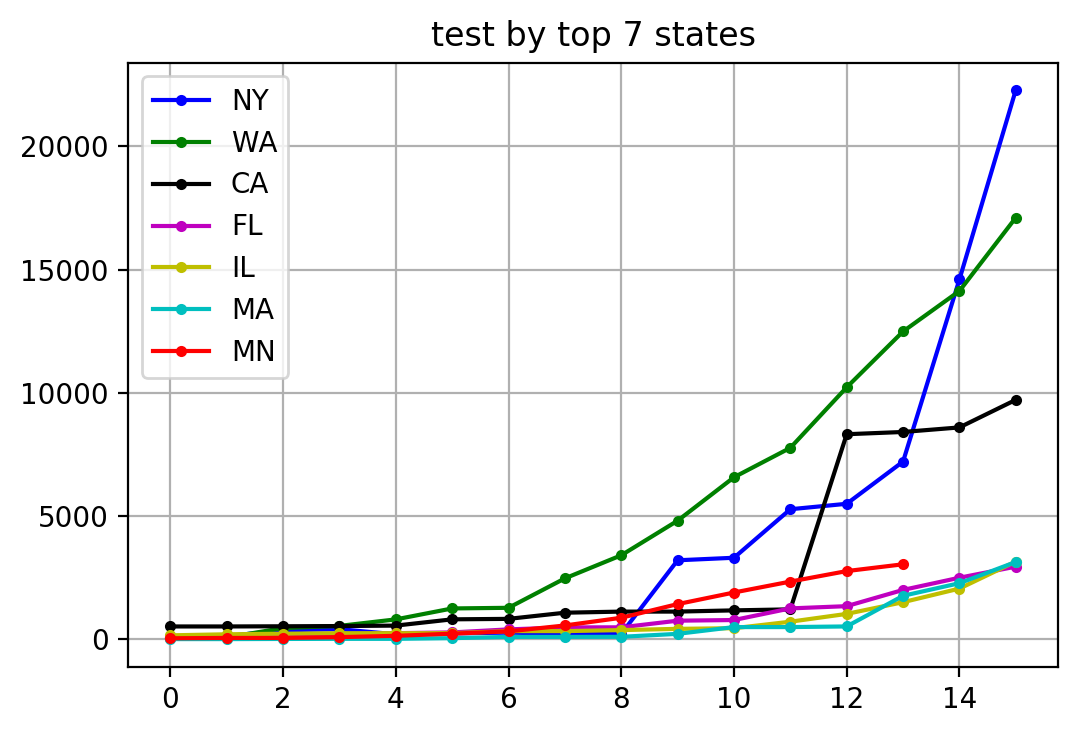

In [9]:
# get top 7 states (using  current)
stFocused = dfStates.sort_values(by="total",ascending=False).head(7)["state"]
for st in stFocused:
    y = dfTStates[dfTStates["state"]==st].sort_values(by='date',ascending=True)["total"].values
    plt.plot(y,label=st)
plt.legend()
plt.grid()
plt.title("test by top 7 states");


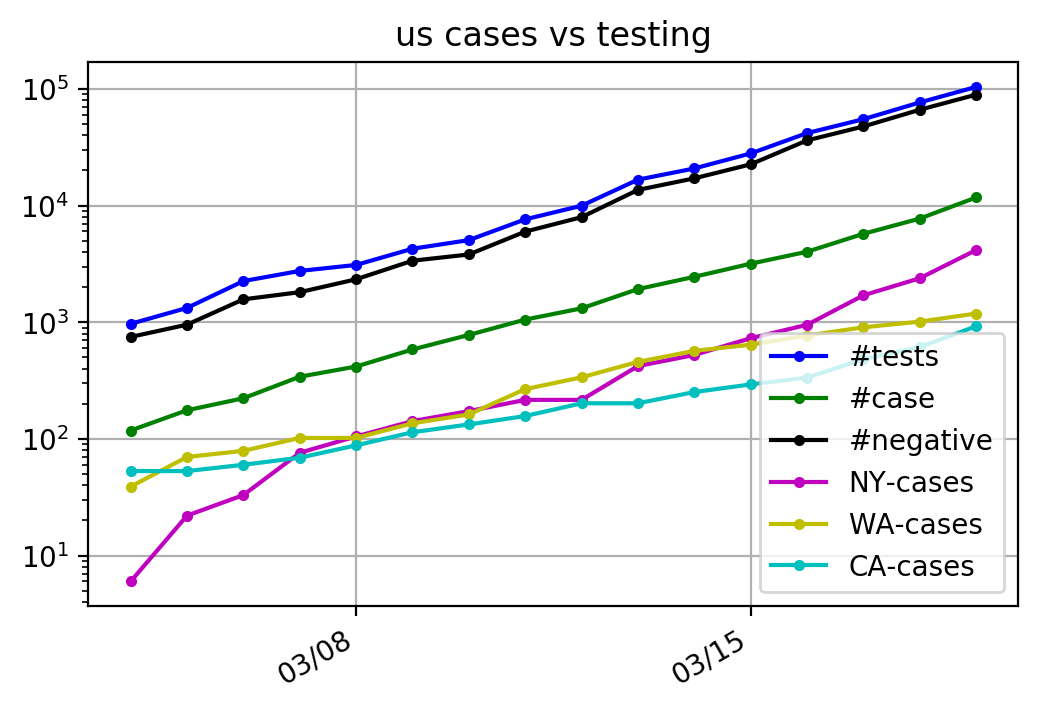

In [10]:
fig,ax = plt.subplots(1,1)
ax.semilogy(dfUST['total'],   label="#tests")
ax.semilogy(dfUST['positive'],label="#case")
ax.semilogy(dfUST['negative'],label="#negative")
for idx in np.arange(0,3):
    y = dfTStates[dfTStates["state"]==stFocused.values[idx]].sort_values(by='date',ascending=True)["positive"]
    ax.semilogy(y,label="%s-cases"%stFocused.values[idx])


ax.grid()
ax.xaxis.set_major_locator(myLocator)
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("us cases vs testing");
plt.legend()
fig.autofmt_xdate()
idx= 0

In [11]:
# create new groups
# dont use string for UR, but the 50 states

northAmer = ["US","Canada","Mexico"],
asia      = ["South Korea","Taiwan","Japan"]   
middleEast=["Iraq","Egypt","Iran"]
countries={ "NoChina":"NoChina",
            "North America":northAmer,
            "Europe":"Europe",            
            "middle east":middleEast,
            "China":"China",
            "South Korea":"South Korea",
            "Japan":"Japan",
            "Italy":"Italy",            
            "South Korea":"Korea, South",
            "US":"US"}


Growth Rate NoChina:1.15
Growth Rate China:1.06
Growth Rate Korea, South:1.10
Growth Rate Europe:1.17


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\scimath.py:310: RuntimeWarning: divide by zero encountered in log10
  return nx.log10(x)


<Figure size 1200x800 with 0 Axes>

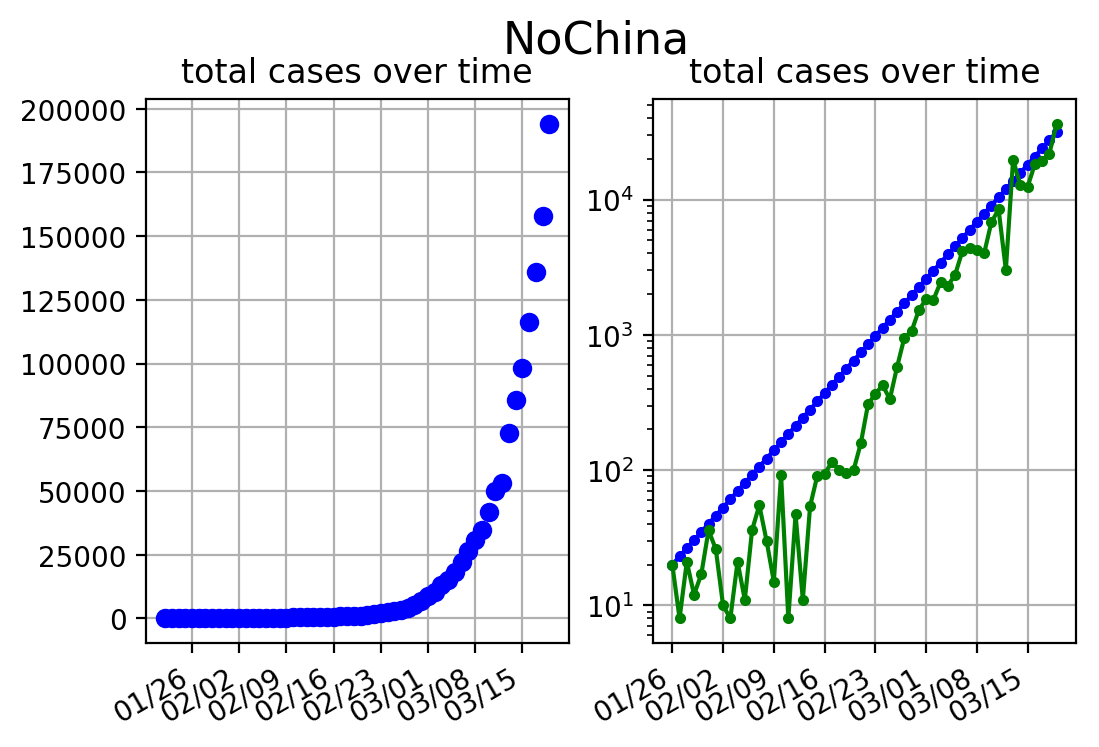

<Figure size 1200x800 with 0 Axes>

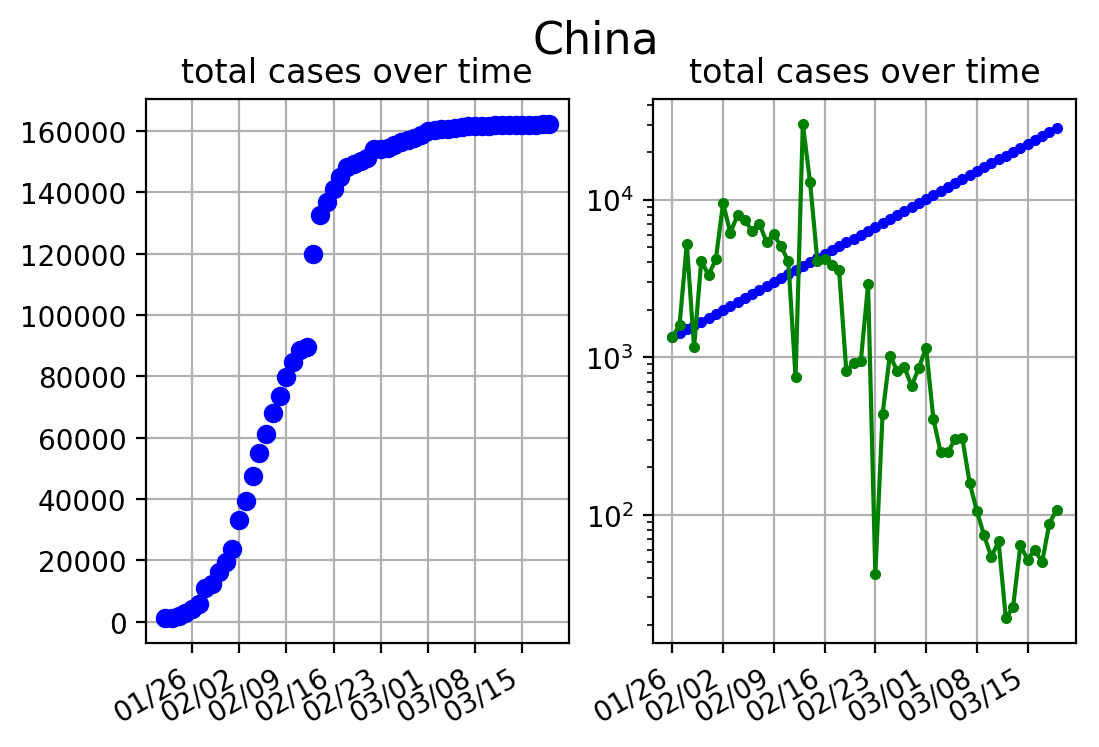

<Figure size 1200x800 with 0 Axes>

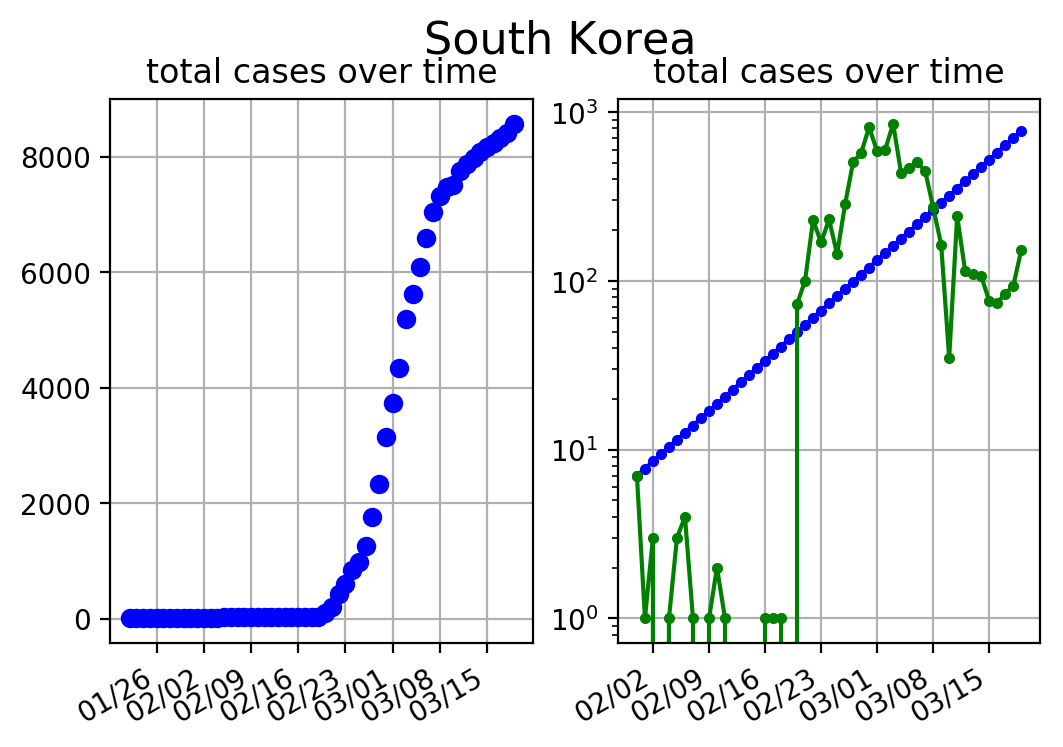

<Figure size 1200x800 with 0 Axes>

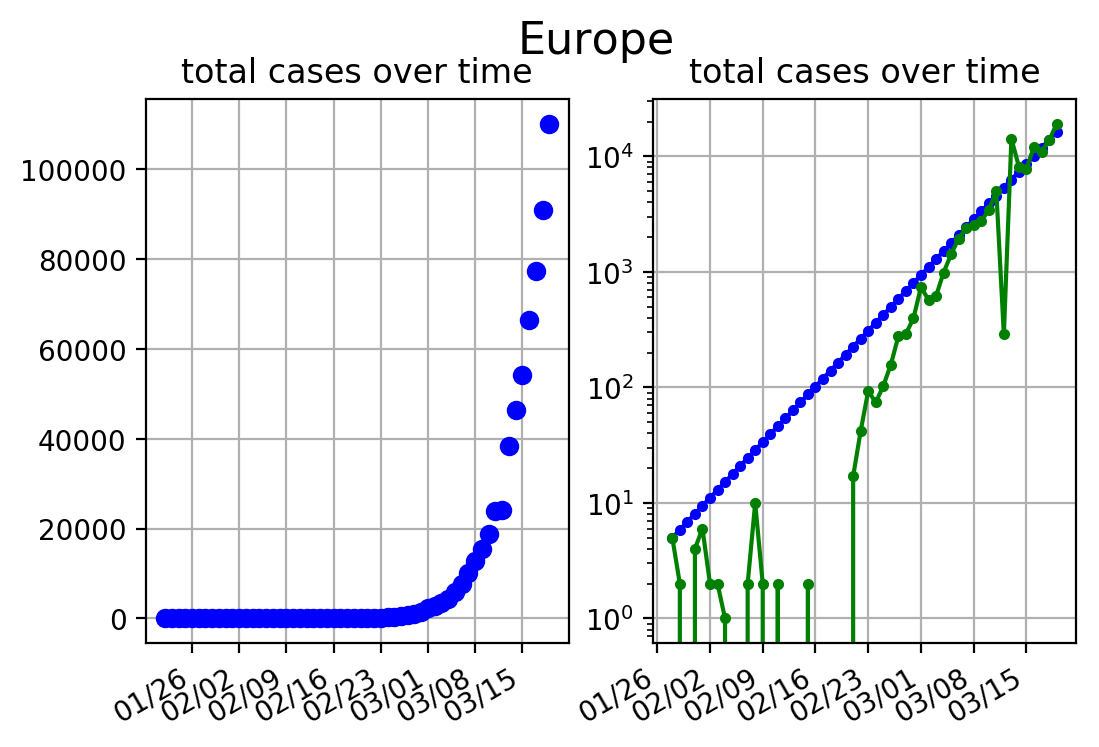

In [12]:
#assume (1+E*P) is 120%


#determine slope and plot
for name in ["NoChina","China", "South Korea", "Europe"]:
    ctr = countries[name]
    plt.figure()
    vals= data.loc[ctr].sum().diff()
    idx = np.argwhere(vals>0)[3][0]

    #print(idx)
    vals = vals[idx:]
    lv = sp.log10(vals)
    m=(max(lv)-lv[0])/(sp.size(lv))

    print("Growth Rate %s:%.2f"%(ctr,math.pow(10,m)))
    #print()
    
    fig, ax = plt.subplots(1,2)
    #---
    ax[1].plot(vals.index,pow(10,np.arange(0,sp.size(lv))*m+lv[0]))
    ax[1].semilogy(vals)
    ax[1].grid()
#    ax[1].legend()
    ax[1].xaxis.set_major_locator(myLocator)
    ax[1].xaxis.set_major_formatter(myFmt)
    ax[1].set_title("total cases over time");

    fig.autofmt_xdate()
    
    #---
    y=data.loc[ctr].sum()
    ax[0].plot_date(y.index,y.values)        
    ax[0].grid()
#    ax[0].legend()
    ax[0].xaxis.set_major_locator(myLocator)
    ax[0].xaxis.set_major_formatter(myFmt)
    ax[0].set_title("total cases over time");

    fig.autofmt_xdate()
    
    fig.suptitle('%s'% name, fontsize=16)


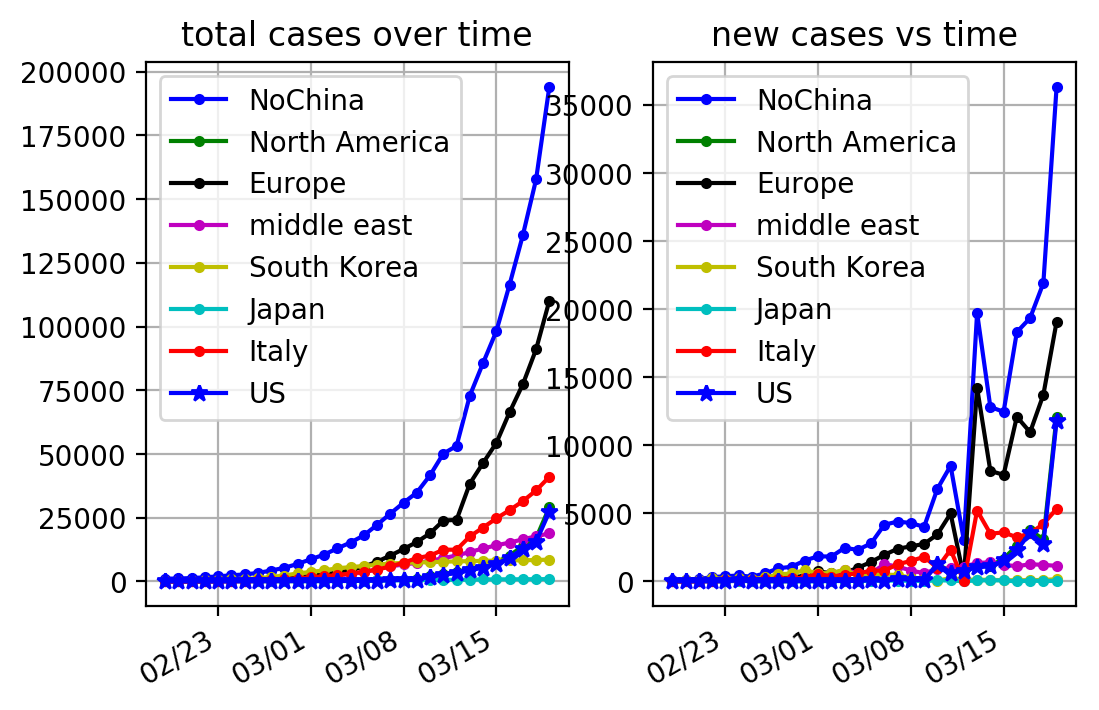

In [13]:
offset=28
#ignore china here
fig, ax =plt.subplots(1,2)
for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    y = data.loc[(country)].sum()
    ax[0].plot(y.index[offset:],y.values[offset:],label=name)
#ax[0].xaxis.set_major_locator(myLocator)
ax[0].grid()
ax[0].legend()
ax[0].xaxis.set_major_locator(myLocator)
ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_title("total cases over time");


for name in countries.keys():
    if name =="China":continue
    country = countries[name]
    
    vals= data.loc[(country)].sum().diff()
    ax[1].plot(vals[offset:],label=name)
ax[1].xaxis.set_major_locator(myLocator)
ax[1].grid()
ax[1].xaxis.set_major_formatter(myFmt)
ax[1].legend()
ax[1].set_title("new cases vs time");

fig.autofmt_xdate()



# Smarter  model

Y' = A * sech^2( B * (t-C) )

Y = A/B * ( tanh( B * (t-C)) + 1 )

The equation for Y is just the integral of the equation for Y', where I have set the constant of integration to make the curve start at zero cases so far.

A = the peak infection rate (4600 case/day)

B = the width parameter (0.116)

C = the center date (2/6/2020 3AM)

sech z = 1/cosh z

       = 2/(e^z+e^-z)


 
# references

franklin antonio

https://royalsocietypublishing.org/doi/pdf/10.1098/rspa.1927.0118

 

The Epidemic Curve parts I & II, Wilson & Burke, 1942,1943

Proc Natl Acad Sci U S A. 1942 Sep; 28(9): 361–367

Proc Natl Acad Sci U S A. 1943 Jan; 29(1): 43–48

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078491/pdf/pnas01644-0025.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1078553/pdf/pnas01648-0050.pdf


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1200x800 with 0 Axes>

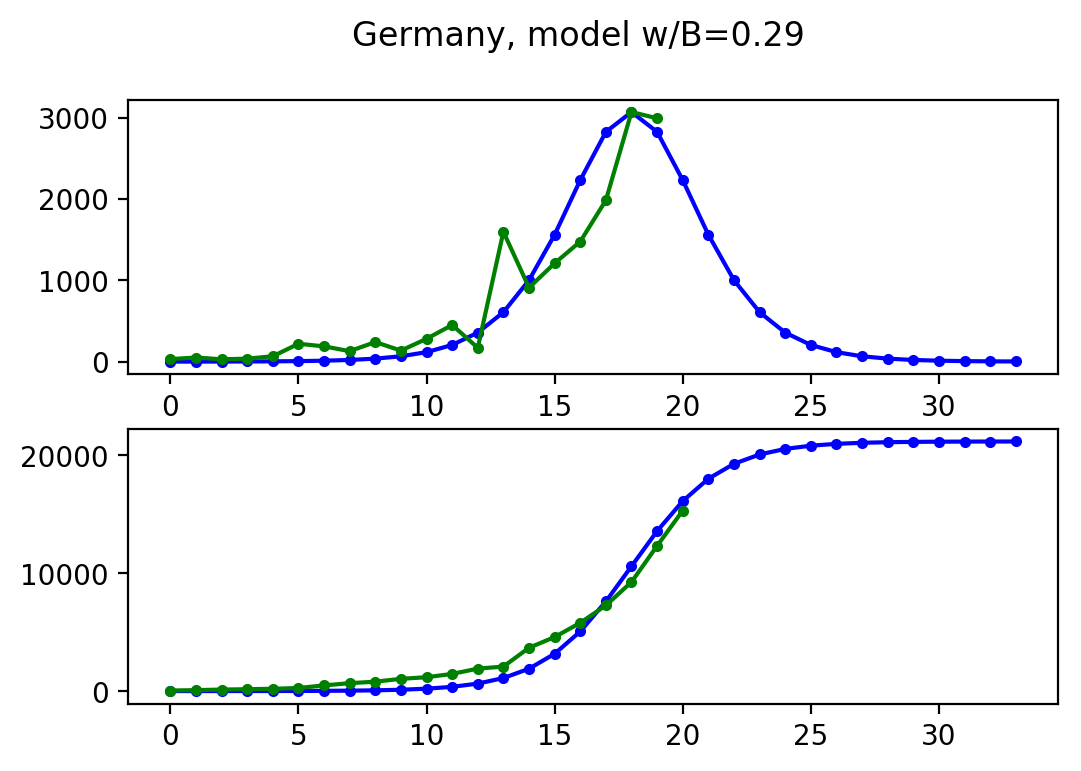

<Figure size 1200x800 with 0 Axes>

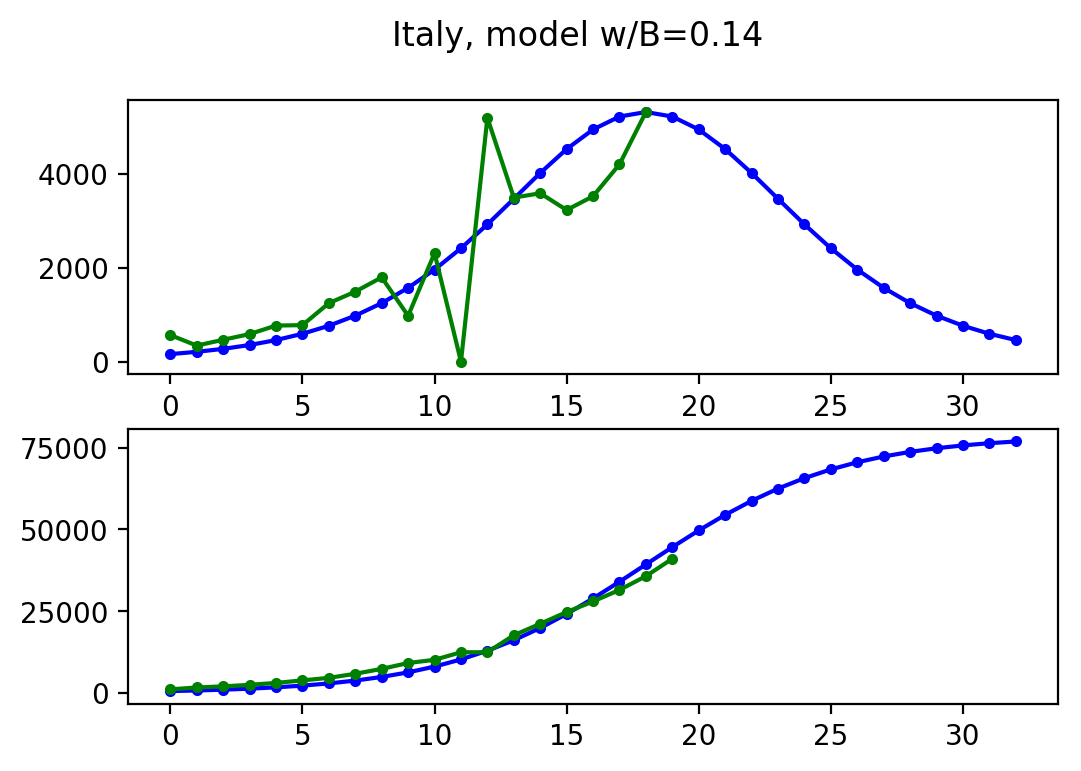

<Figure size 1200x800 with 0 Axes>

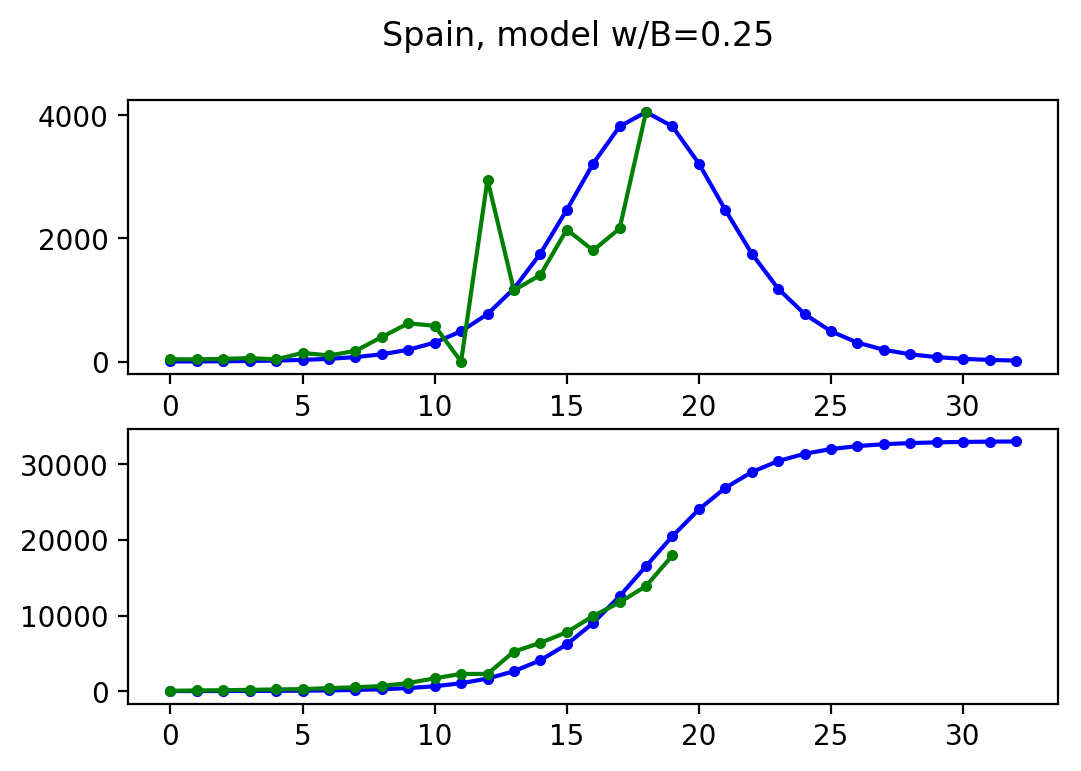

<Figure size 1200x800 with 0 Axes>

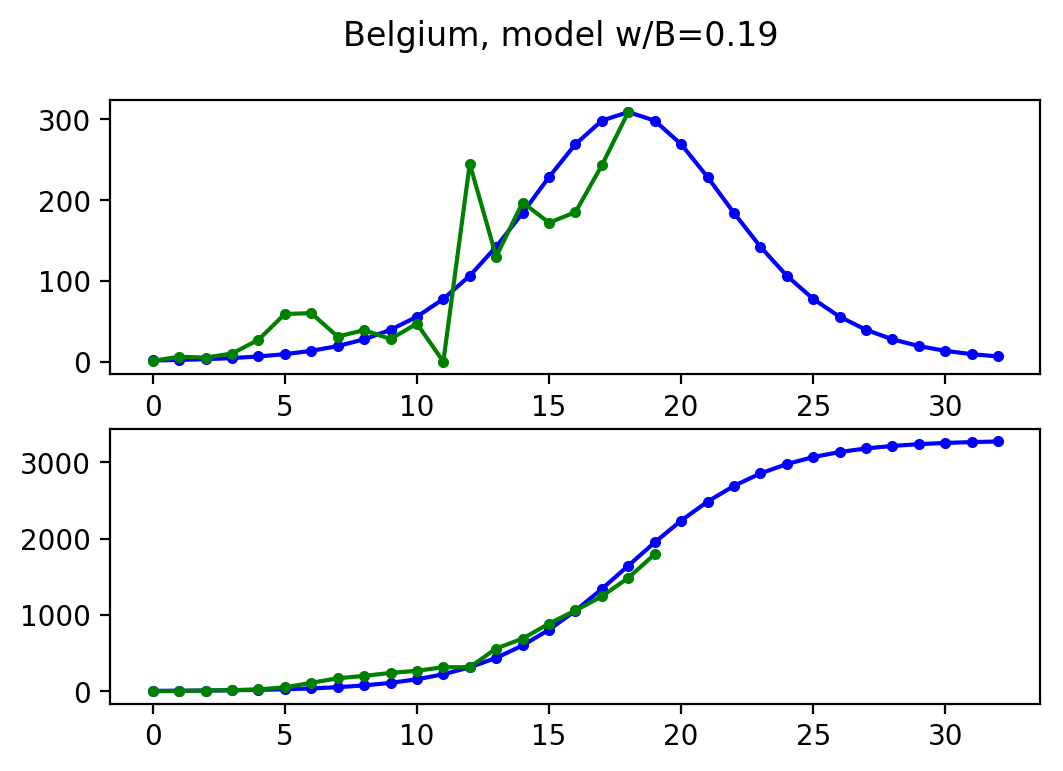

<Figure size 1200x800 with 0 Axes>

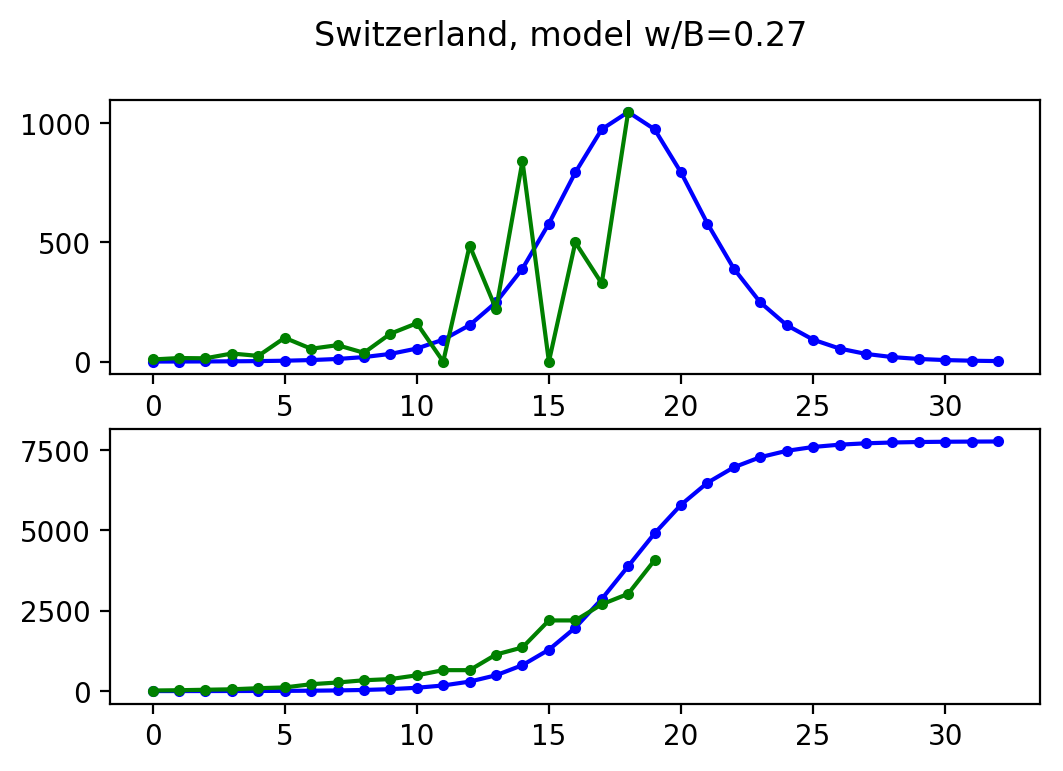

<Figure size 1200x800 with 0 Axes>

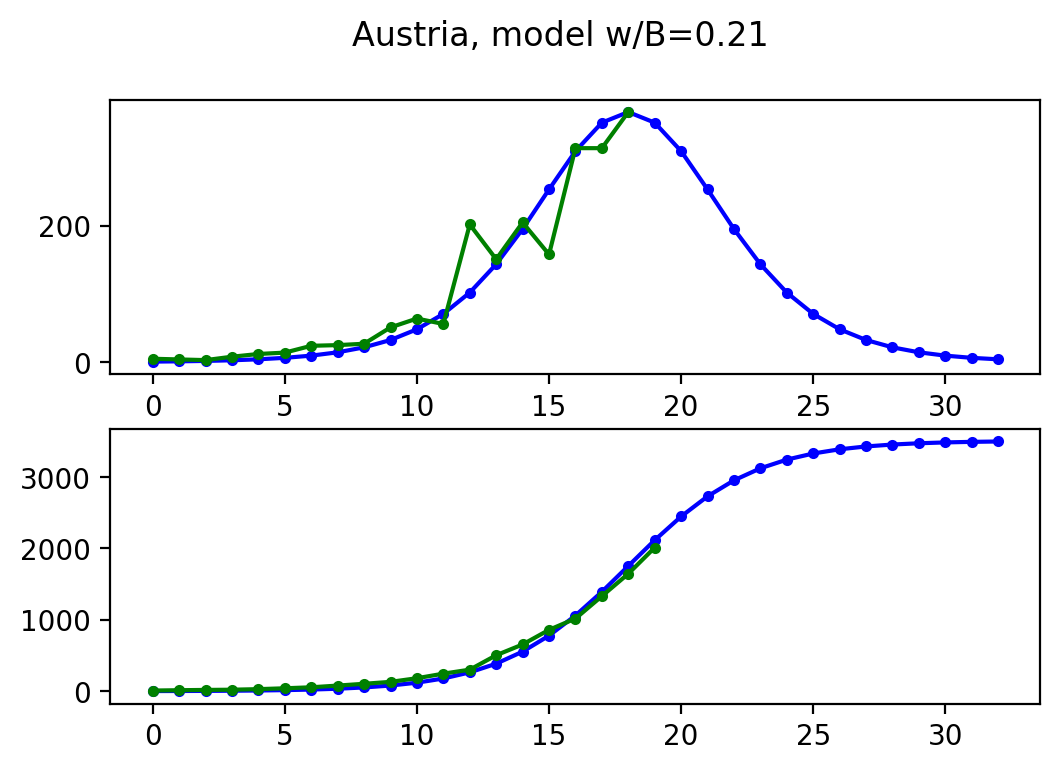

<Figure size 1200x800 with 0 Axes>

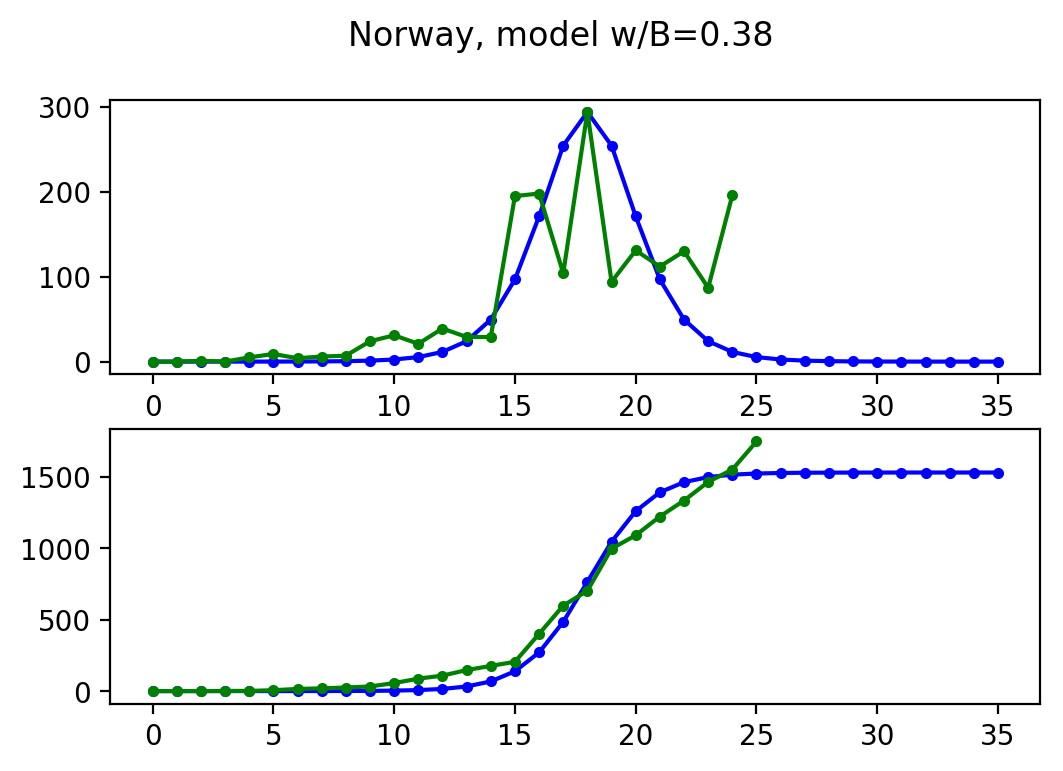

<Figure size 1200x800 with 0 Axes>

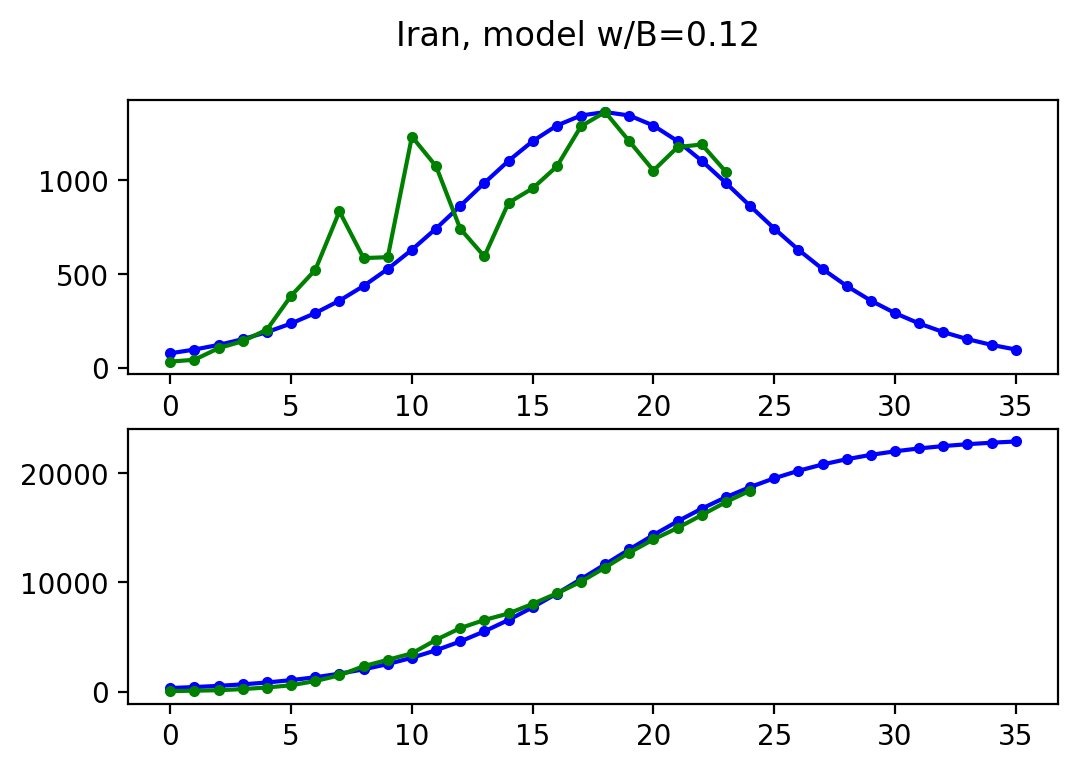

<Figure size 1200x800 with 0 Axes>

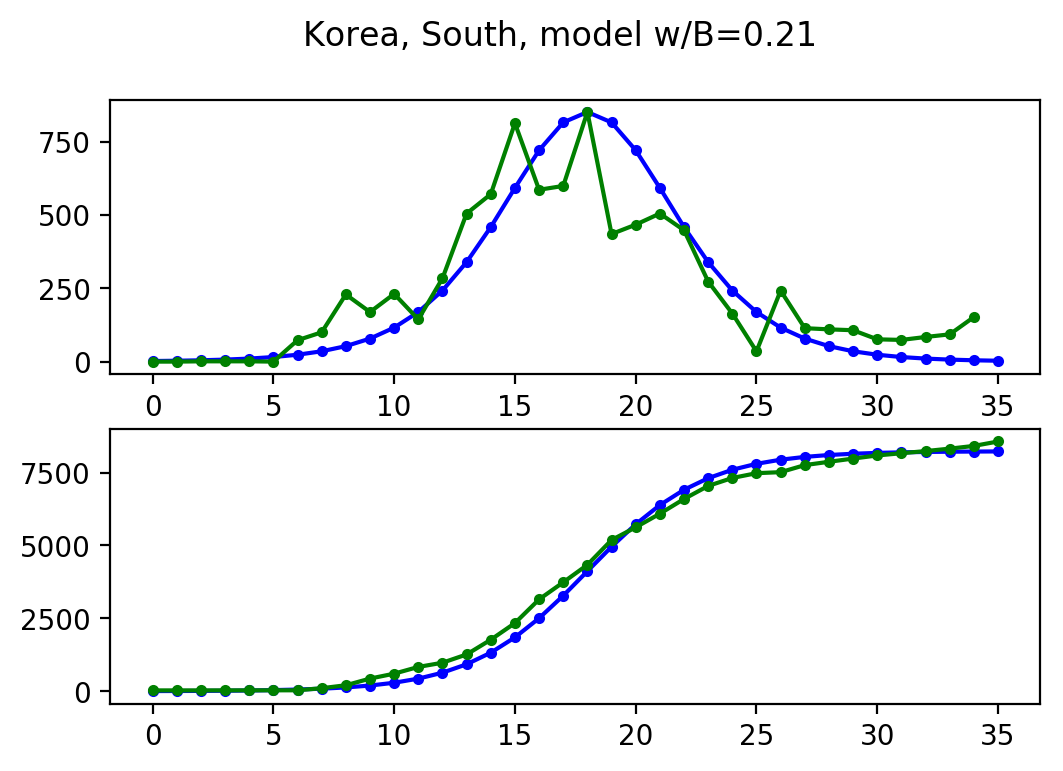

<Figure size 1200x800 with 0 Axes>

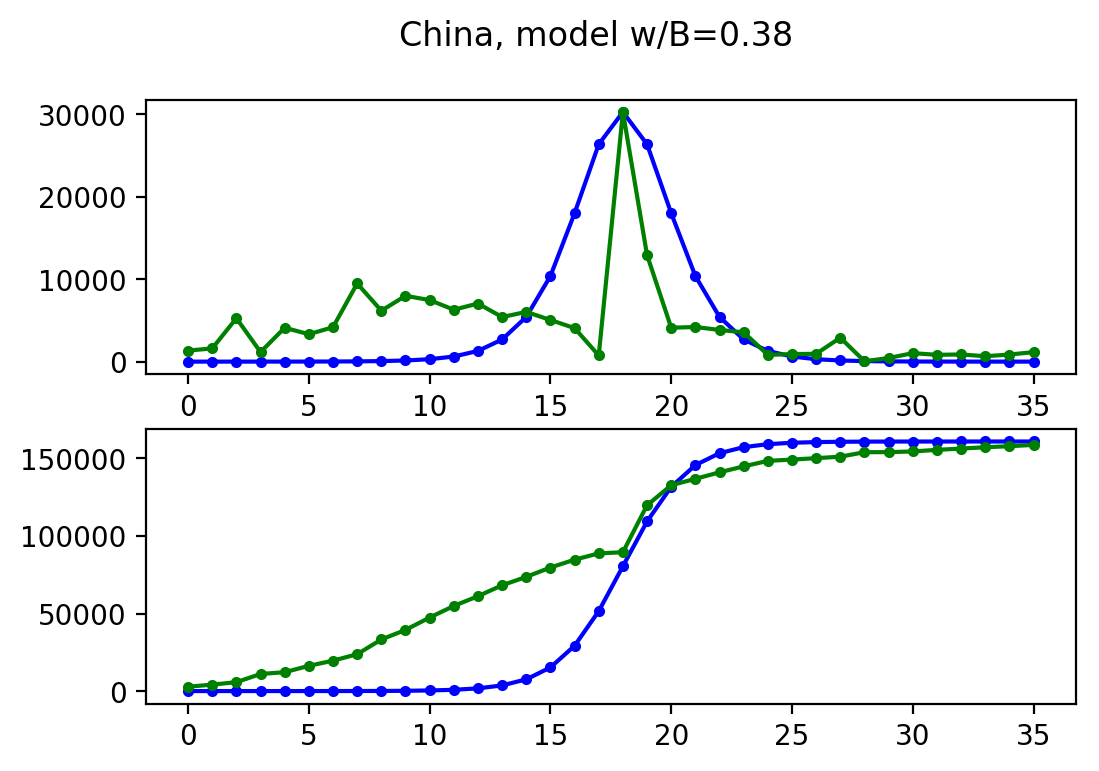

<Figure size 1200x800 with 0 Axes>

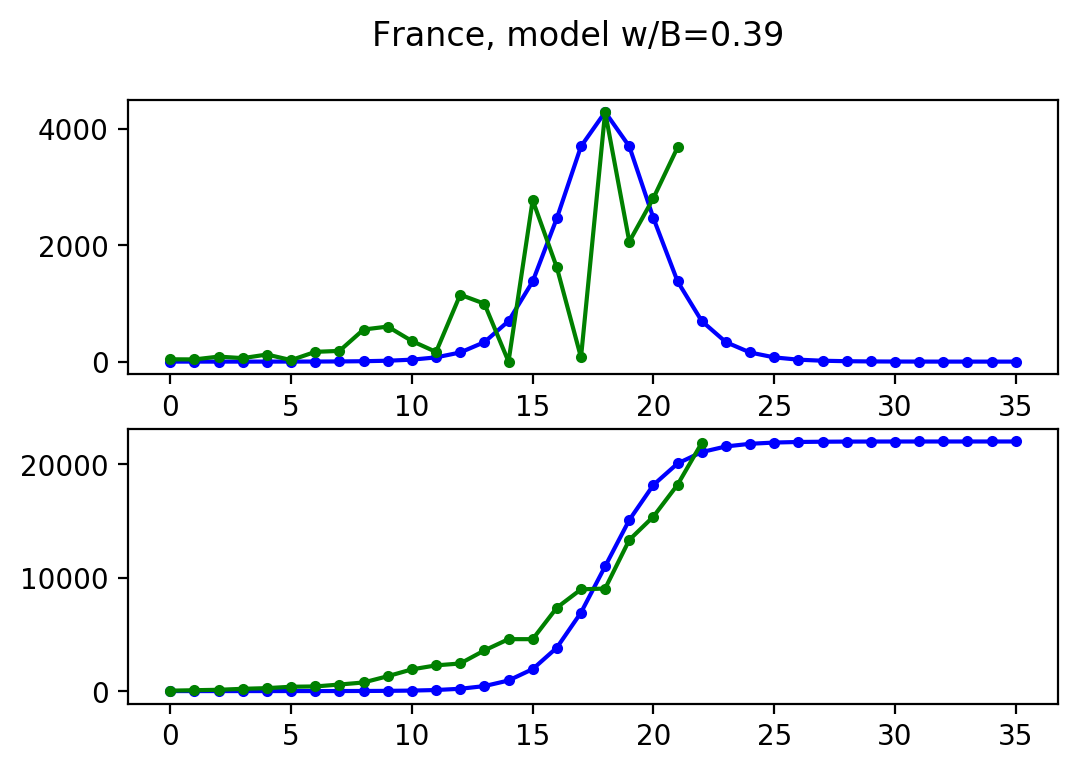

<Figure size 1200x800 with 0 Axes>

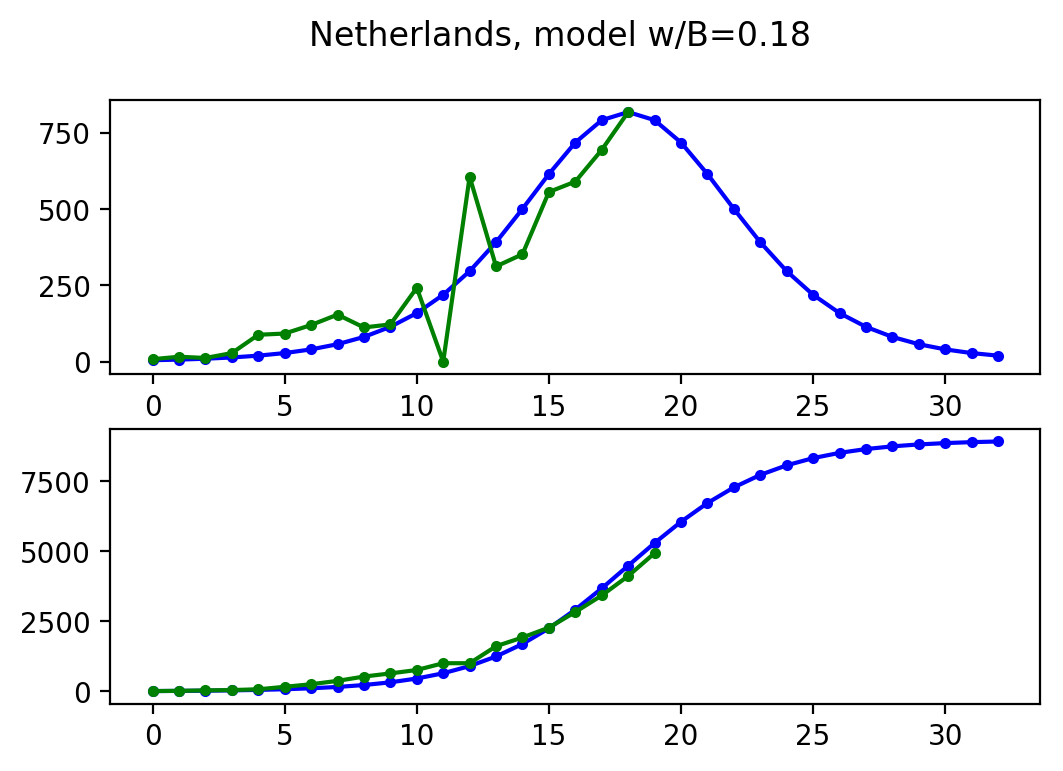

<Figure size 1200x800 with 0 Axes>

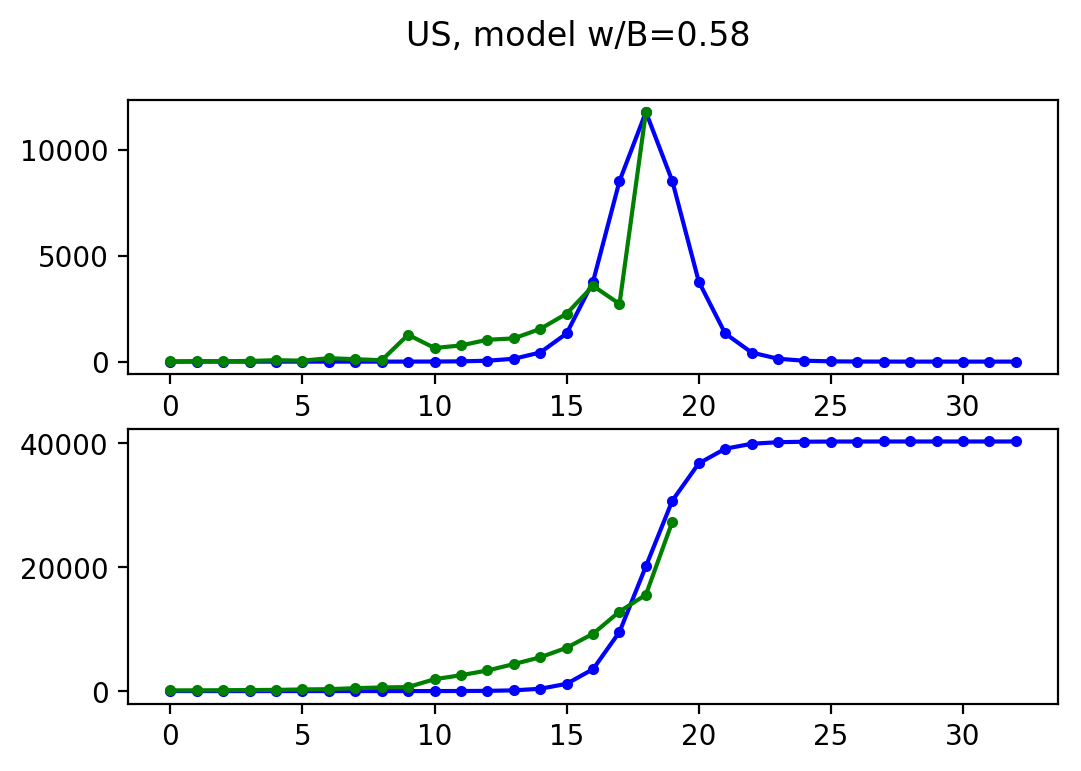

<Figure size 1200x800 with 0 Axes>

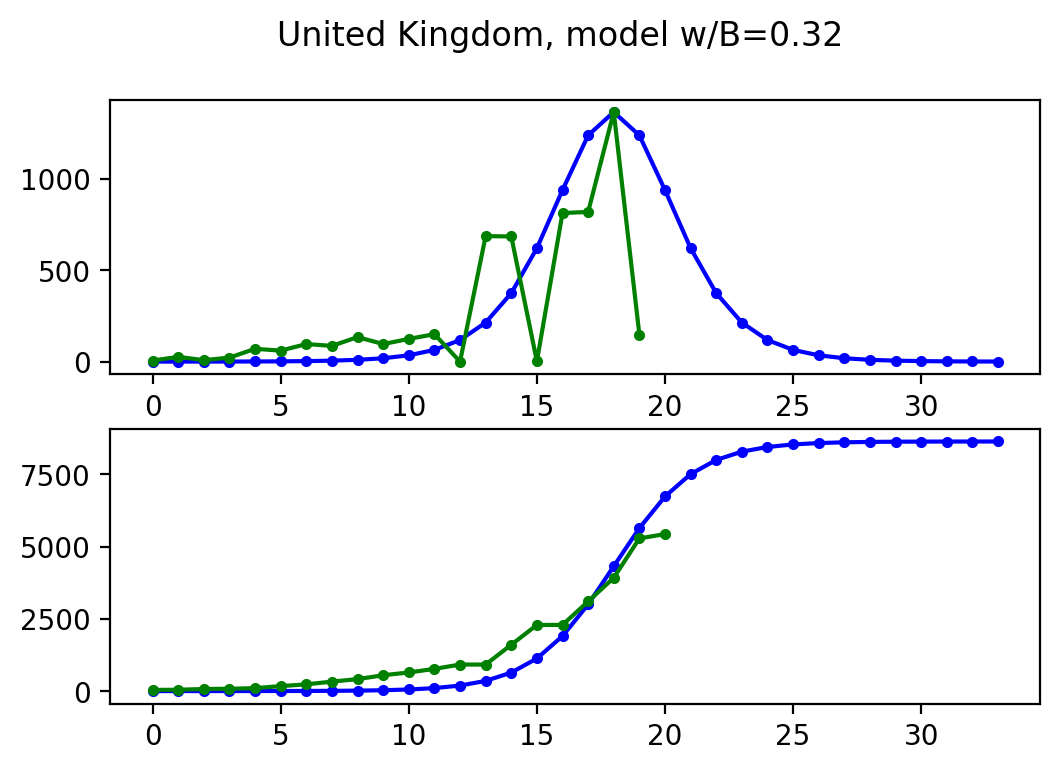

<Figure size 1200x800 with 0 Axes>

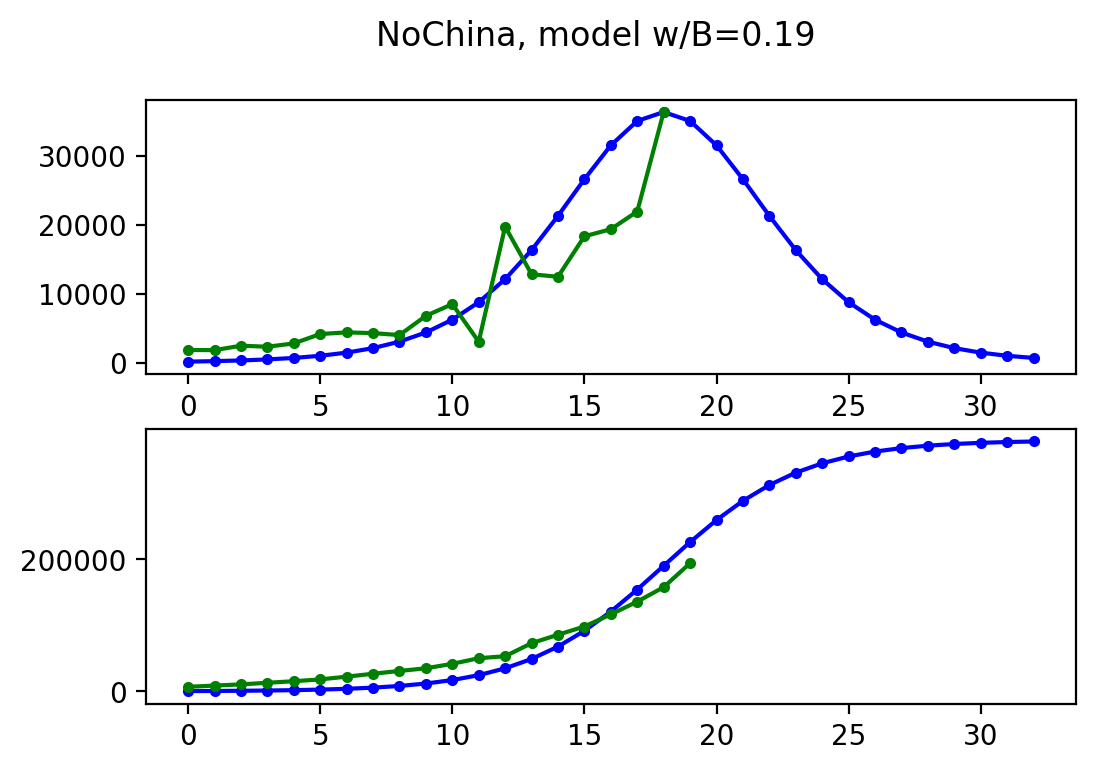

<Figure size 1200x800 with 0 Axes>

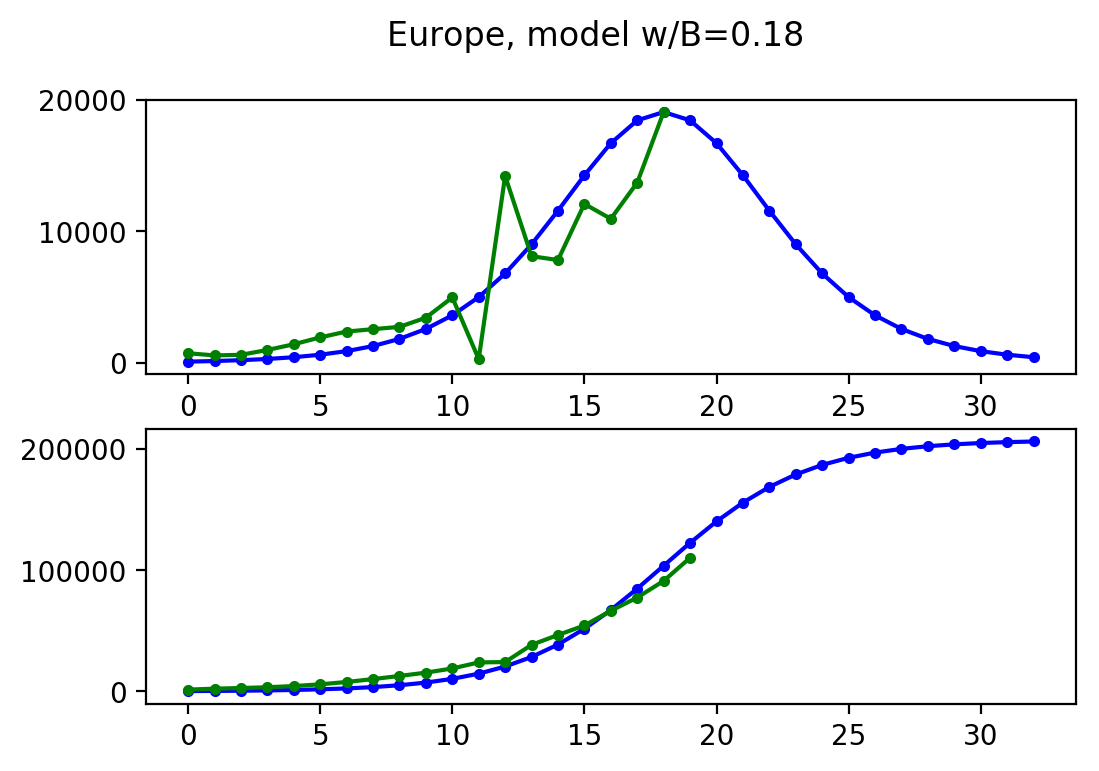

<Figure size 1200x800 with 0 Axes>

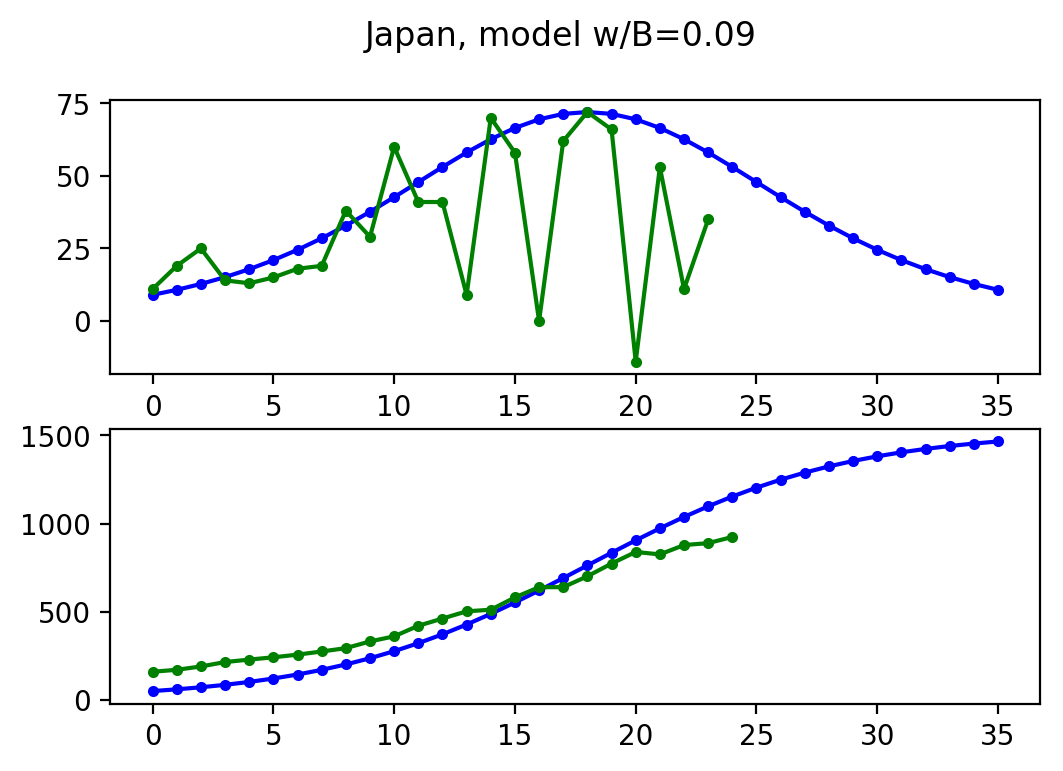

In [14]:
# place a model on all countries with high counts

for ctr in countriesFocused:
    plt.figure()
    # get daily change, drop first value, '0'
    v = dataJHU.loc[ctr].sum().diff().values[1:]
    y = dataJHU.loc[ctr].sum().values
    
    #A/C are derived, 
    A=max(v)
    C=np.argmax(v)
    # this is width variable, smaller means slower groth (this is a guss)
    # first run wiht a good set then adjust to target (for example run with south kora)
    def model(t,A,C,B):    
        return A/B * ( np.tanh( B * (t-C)) + 1 )
    f = lambda t,B: model(t, A, C,B)
    t = np.arange(0,sp.size(y))
    params, params_covariance = optimize.curve_fit(f, t, y,
                                               p0=[.2])
    
    B=params[0]
     
    #number of samples to plot is inversely releated to B
    M = 18# 2.5 weeks

    # must be in days
    N=sp.size(v)
    t = np.arange(0,N+14)
    yh = A/B * ( np.tanh( B * (t-C)) + 1 )

    vh = A/(np.cosh( B * (t-C))**2)
    fig, ax = plt.subplots(2,1,)
    label="%s, model w/B=%.2f" % (ctr,B)
    ax[0].plot(vh[C-M:C+M])
    ax[0].plot(v[C-M:C+M])
    fig.suptitle(label)
    ax[1].grid()
    ax[1].plot(yh[C-M:C+M])
    
    ax[1].plot(y[C-M:C+M])
    
    ax[1].grid()



        Germany 2020-03-12:-11
          Italy 2020-03-02:-1
          Spain 2020-03-11:-10
           Iran 2020-03-03:-2
   Korea, South 2020-02-28:2
          China 2020-01-26:35
         France 2020-03-11:-10
             US 2020-03-13:-12
        NoChina 2020-02-24:6
         Europe 2020-03-01:0


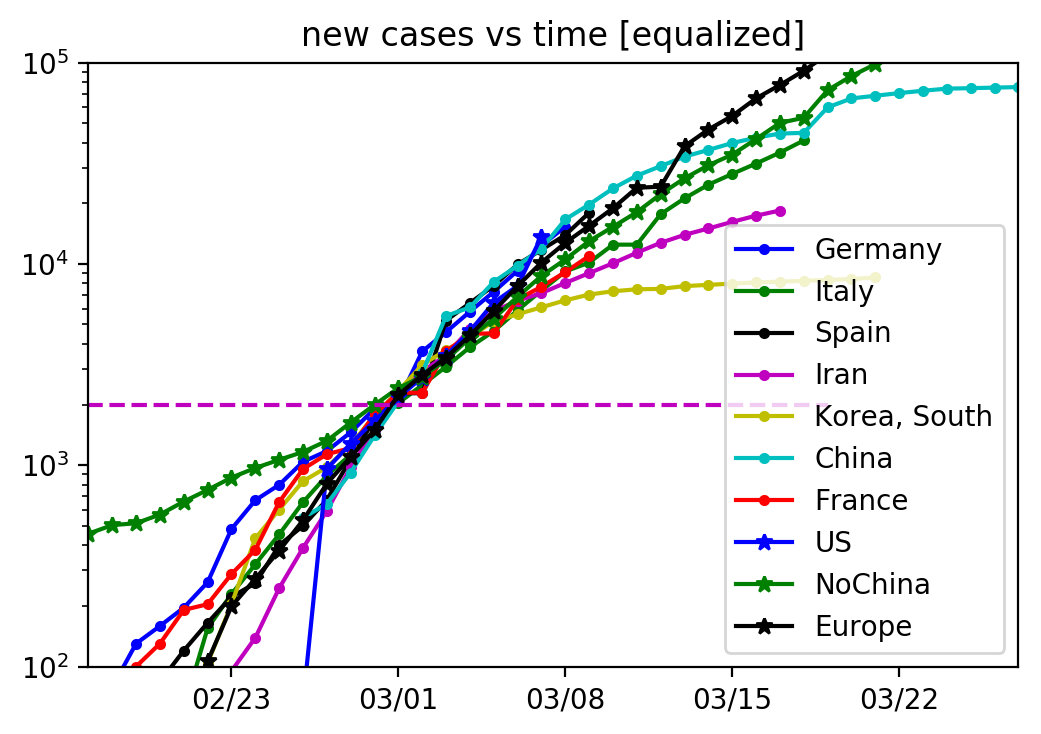

In [78]:
#align countries, with the following offset to get a prediction where they are 
# ideally normalize too


N= 2000;# number of sample to align too
M= 8000;# minimum case count
# find reference time stamp of passing N samples                  
idx = pd.IndexSlice
id = np.argmax((dataJHU.loc[idx["Europe",:,:,:],:]> N).values[0]==True)
dtRef = dataJHU.columns[id]

dt = dataJHU.columns[-1]
                  
fig, ax=plt.subplots(1,1)
#only consider countires with large number of cases
for index, row in dataJHU[dataJHU[dt]>M].iterrows():
    ctr =index[0]    
    #ignore states
    if index[1] != "NA": continue 
    #equalize start data to be at N cases and to ref country (US)
    dtg = row[row>N].first_valid_index()
    do  = datetime.timedelta((dtRef - dtg).days)
    print("%15s %s:%d"%(ctr,dtg.date(),do.days))
    #do  =datetime.timedelta(days=offsets[ctr])
    vdt = [(d +do).date()#.strftime("%m/%d")
           for d in dataJHU.columns]
    
    ax.semilogy(vdt,row.values, label=ctr)
ax.semilogy(vdt,np.ones(sp.size(vdt)) * N, '--')    
#ax.xaxis.set_major_locator(myLocator)
ax.grid()
#control range to zoom regio of interest
ax.set_ylim(1e2, 1e5)
ax.set_xlim(datetime.date(2020, 2, 17), datetime.date.today()+datetime.timedelta(7))
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("new cases vs time [equalized]");


In [75]:
dataJHU[dataJHU[dt]>M]

,,,,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,...,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00
Country/Region,Province/State,Lat,Long,,,,,,,,,,,,,,,,,,,,,
Germany,NA,51.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,...,1457.0,1908.0,2078.0,3675.0,4585.0,5795.0,7272.0,9257.0,12327.0,15320.0
Italy,NA,43.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,10149.0,12462.0,12462.0,17660.0,21157.0,24747.0,27980.0,31506.0,35713.0,41035.0
Spain,NA,40.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1695.0,2277.0,2277.0,5232.0,6391.0,7798.0,9942.0,11748.0,13910.0,17963.0
China,Hubei,30.9756,112.2707,444.0,444.0,549.0,761.0,1058.0,1423.0,3554.0,3554.0,4903.0,5806.0,...,67760.0,67773.0,67781.0,67786.0,67790.0,67794.0,67798.0,67799.0,67800.0,67800.0
Iran,NA,32.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8042.0,9000.0,10075.0,11364.0,12729.0,13938.0,14991.0,16169.0,17361.0,18407.0
"Korea, South",NA,36.0,128.0,1.0,1.0,2.0,2.0,3.0,4.0,4.0,4.0,4.0,11.0,...,7513.0,7755.0,7869.0,7979.0,8086.0,8162.0,8236.0,8320.0,8413.0,8565.0
France,France,46.2276,2.2137,0.0,0.0,2.0,3.0,3.0,3.0,4.0,5.0,5.0,5.0,...,1784.0,2281.0,2281.0,3661.0,4469.0,4499.0,6633.0,7652.0,9043.0,10871.0
China,NA,NA,NA,548.0,643.0,920.0,1406.0,2075.0,2877.0,5509.0,6087.0,8141.0,9802.0,...,80887.0,80921.0,80932.0,80945.0,80977.0,81003.0,81033.0,81058.0,81102.0,81156.0
France,NA,NA,NA,0.0,0.0,2.0,3.0,3.0,3.0,4.0,5.0,5.0,5.0,...,1792.0,2290.0,2290.0,3678.0,4487.0,4523.0,6668.0,7699.0,9105.0,10947.0


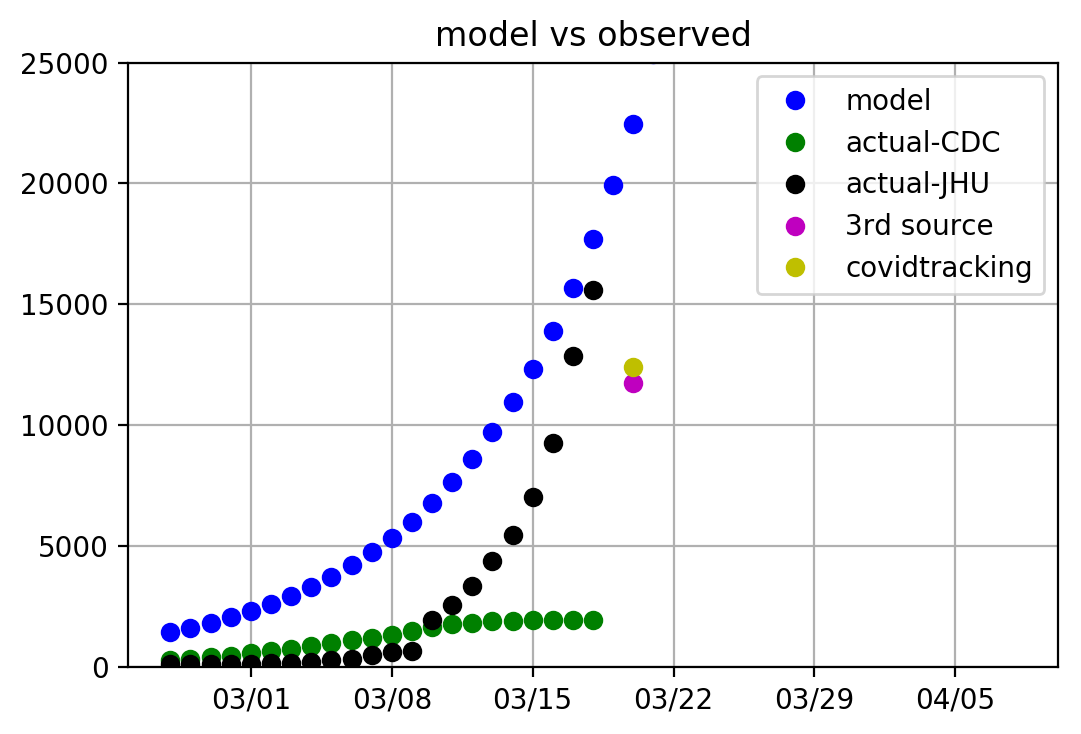

In [16]:
 #try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# use JHU
# estimate US data

idx = pd.IndexSlice

#find cumulateive greater then 50, this will be y0
startDate = dataCdc[dataCdc>250].index[0]
rate = .12

#start from scratch take y[0] and assume X% groth and assume, y0 was 20% report of all reporting (multiply by 5)
# get number of samples in the data base
N = (datetime.date.today()-startDate).days

#project for another 2 week
NP = 20
NEC = (datetime.date.today()    -dataCdc.index[-1]).days-1
NEJ = (datetime.datetime.today()-dataJHU.columns[-1] ).days-1


# projection (assume multipler of 5)
yh = dataCdc[startDate] * 5 * np.exp(rate * np.arange(0,N+NP))
yh=yh.astype(int)

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,N+NP)]
fig, ax = plt.subplots(1,1)

ax.plot_date(x,
             yh,
             label="model")
ax.plot_date(x[0:(N-NEC)],
             dataCdc[startDate:].values,
             label="actual-CDC")
ax.plot_date(x[0:(N-NEJ)],
             dataJHU.loc["US",startDate:].sum().values,
             label="actual-JHU")
ax.plot_date(datetime.date.today(),
             dataCS.loc[idx["NA", "NA", "NA", "USA"],"cases"],
            label="3rd source")

ax.plot_date(datetime.date.today(),
        dataCovTr["positive"],
        label="covidtracking")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("model vs observed")
ax.set_ylim(0, 25000)


yc = np.concatenate([dataCdc.loc[startDate:].values,
                     np.nan * np.ones(NP+NEC)])


yj = np.concatenate([dataJHU.loc["US",startDate:].sum().values,
                    np.nan * np.ones(NP+NEJ)])


if(1):
    df =pd.DataFrame({"model": yh,
                  "cdc"  : yc,
                  "jhu"  : yj},index=x)
    #print(df)


2020-02-07 00:00:00


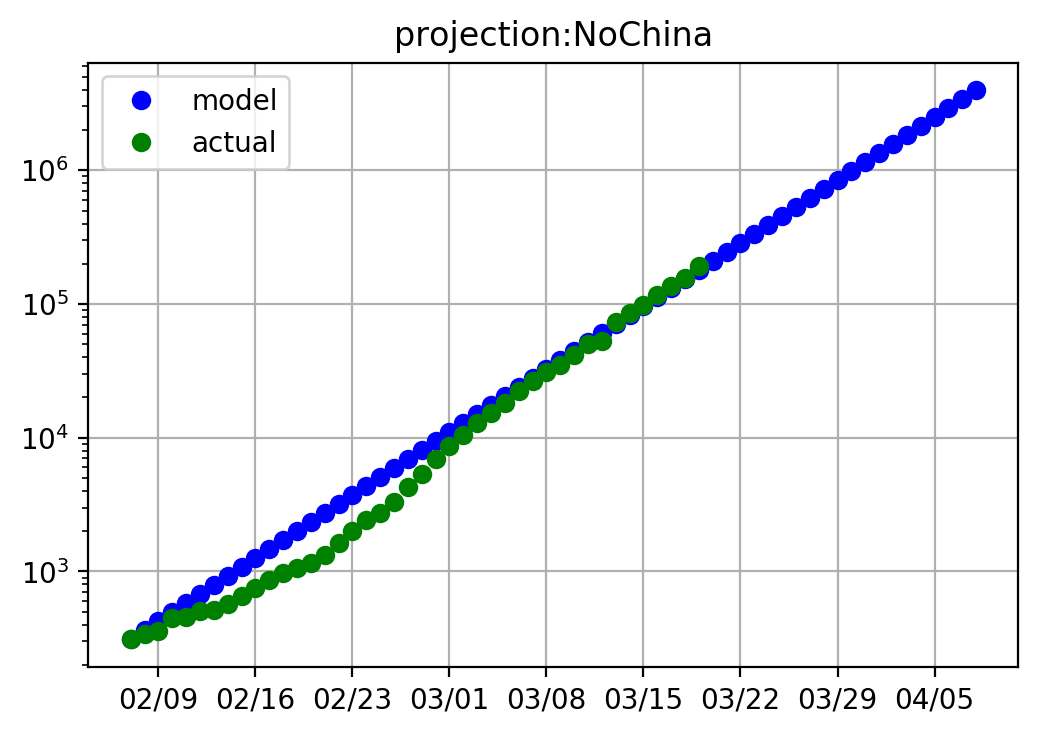

In [17]:
# try to predict the 'US' covid-19 number of illness, will adapt the rate, note this will only reflect
# the positive exponent of the logistic curver (at the inflection points switchs from exponential to logarithmic)
# https://en.wikipedia.org/wiki/Generalised_logistic_function
# assuming a groth rate of 10%
#where will the us be
#start date
rate      = .155
ctr       = "NoChina"
caseMin   = 300
TN        = 21     # number of intervals after today



s = dataJHU.loc[ctr].sum()
startDate = s[s>caseMin].index[0]

print(startDate)

#nmber of intervals
N  = sp.size(dataJHU.columns)


# Set the epoch value
Y0 = dataJHU[startDate][ctr].sum()
#determine time offset
offset = (dataJHU.columns[-1]-startDate).days
Yt =Y0 * sp.exp(rate * np.arange(0,offset + TN))

x = [startDate+datetime.timedelta(days=int(i)) for i in np.arange(0,offset + TN)]
NE = (datetime.datetime.today()-dataJHU.columns[-1] ).days


fig,ax = plt.subplots(1,1)
ax.plot_date(x,
             Yt,
             label="model")



ax.plot_date(x[:(offset+NE)],
             dataJHU.loc[ctr,startDate:].sum(),
             label="actual")
ax.xaxis.set_major_locator(myLocator)
ax.grid()
ax.xaxis.set_major_formatter(myFmt)
ax.legend()
ax.set_title("projection:%s"%ctr)
#ax.set_ylim(0, 50000)
plt.yscale('log')



In [18]:
#script for scraping HTML sites 
# investigate  java scripts for cleaner solution, need to inspect and find source
import re,pickle, requests
try:
    from bs4 import BeautifulSoup
except ImportError:
    !pip install packaging
    from bs4 import BeautifulSoup


URL = 'https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')




table = soup.find("div",{"class":"table parbase section"})
rows = table.find_all('tr')

# handle header
header = [row.text for row in rows[1].find_all('td')]
header = [re.sub('[ \t\n]+', ' ',h)  for h in header]

tbl ={}
for row in rows[2:]: #skip the first row
    data = [r.text for r in row.find_all('td')]    
    if data[1] =='\xa0':continue    
    tbl[data[0]]=[int(d) for d in data[1:]]
df = pd.DataFrame(tbl, index=header[1:])
display(HTML(df.to_html()))
updateDateTime = rows[0].find('td').text.split('\n')[-1].replace("Updated","")
print("last update is%s" % updateDateTime )

dt = datetime.datetime.strptime(updateDateTime.strip(),"%B %d, %Y")
# get data
data = pickle.load( open( "sandiego.tseries.p", "rb" ) )
if not dt in data.keys():
    print("saving new data, with key %s" %dt)
    data[dt] =df
    pickle.dump(data,open("sandiego.tseries.p",'wb'))

,Total Positives,0-9 years,10-19 years,20-29 years,30-39 years,40-49 years,50-59 years,60-69 years,70-79 years,80+ years,Age Unknown,Female,Male,Unknown,Hospitalized,Deaths
San Diego County Residents,89,0,1,17,22,22,13,3,10,1,0,30,57,2,11,0
Federal Quarantine,8,0,0,0,0,0,0,1,2,5,0,3,5,0,1,0
Non-San Diego County Residents,8,0,0,3,2,0,0,0,3,0,0,3,5,0,1,0
Total,105,0,1,20,24,22,13,4,15,6,0,36,67,2,13,0


last update is March 19, 2020 


In [19]:
data = pickle.load(open("sandiego.tseries.p",'rb'))
#specify data to access
dt = datetime.datetime(2020, 3, 17, 0, 0)
data[dt]


,Total Positives,0-17 years,18-64 years,65+ years,Age Unknown,Female,Male,Unknown,Hospitalized,Deaths
San Diego County Residents,51,0,43,8,0,17,34,0,8,0
Federal Quarantine,5,0,1,4,0,2,3,0,1,0
Non-San Diego County Residents,4,0,3,1,0,2,2,0,1,0
Total,60,0,47,13,0,21,39,0,10,0
